Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from datetime import date
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
from torch.autograd import Variable
import warnings
from torch import nn

Add csv and visualize

In [2]:
df1 = pd.read_csv("all_data_v1.0.csv",index_col="timestamp")

df1[:].mask(df1[:] == 9999.0, np.nan, inplace=True)
df1[:].mask(df1[:] == "99999 9", np.nan, inplace=True)
#df.values.astype(float)

df1 = df1.mask(df1.isna(), 0)

df1 = df1.drop(["Kp10","RSP","DST","SOLARF10","AE","AL","AU","PCN","LYMANALPHASOLAR"],axis=1)

df = df1[45000:]

print(df)

                           Bx        By        Bz    E_bin_00   E_bin_01  \
timestamp                                                                  
2021-10-18 00:00:00  4.211990  10.38540 -2.502830  115.796000  47.454000   
2021-10-18 01:00:00  0.354753  11.98620  2.390560  112.032000  44.116800   
2021-10-18 02:00:00  2.140470  12.24420  2.214340  112.042000  43.610900   
2021-10-18 03:00:00  0.377328  12.02540  3.537550  111.361000  43.528100   
2021-10-18 04:00:00  4.500330  10.08340  6.036110  112.031000  44.964100   
...                       ...       ...       ...         ...        ...   
2023-05-02 19:00:00  3.528040   3.05233 -2.094540    0.231726   0.231726   
2023-05-02 20:00:00  3.809430   3.25946 -0.944308    0.231726   0.231726   
2023-05-02 21:00:00  3.918360   2.64597 -1.864430    4.076740   0.231726   
2023-05-02 22:00:00  5.054850   2.91226  0.109500    0.695707   0.231726   
2023-05-02 23:00:00  5.103280   2.11338  1.031840    0.724536   0.231726   

           

<function matplotlib.pyplot.show(close=None, block=None)>

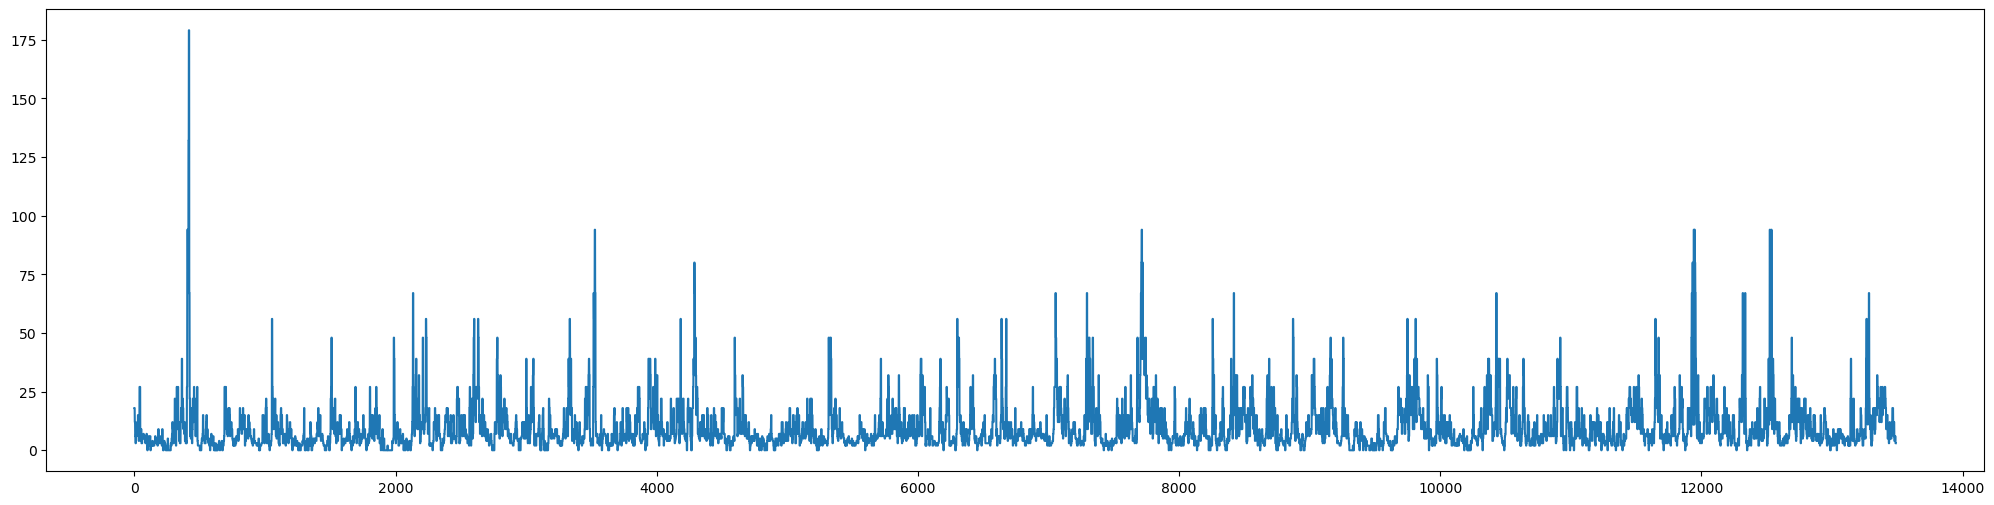

In [3]:
plt.figure(figsize=(25,6))
plt.plot(np.linspace(0,len(df["AP"]),len(df["AP"])),df["AP"])
plt.show

In [4]:
X, y = df.drop(columns=["AP"]), df.AP.values
X.shape,y.shape

((13488, 58), (13488,))

In [5]:
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [6]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)


X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)

total_samples = len(X)
train_test_cutoff = round(0.80 * total_samples)
test_cutoff_samples = total_samples-train_test_cutoff

X_train = X_ss[:-test_cutoff_samples]
X_test = X_ss[-test_cutoff_samples:]

y_train = y_mm[:-test_cutoff_samples]
y_test = y_mm[-test_cutoff_samples:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

(13340, 100, 58) (13340, 50)
Training Shape: (10642, 100, 58) (10642, 50)
Testing Shape: (2698, 100, 58) (2698, 50)


In [7]:
# create a tensor on CPU
x = torch.tensor([1, 2, 3])

if torch.cuda.is_available():
    device = torch.device("cuda")
    x = x.to(device)
    print("Tensor moved to GPU")
else:
    print("GPU is not available, using CPU instead")
    
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))


# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 


Tensor moved to GPU
Training Shape: torch.Size([10642, 100, 58]) torch.Size([10642, 50])
Testing Shape: torch.Size([2698, 100, 58]) torch.Size([2698, 50])


In [8]:
X_check, y_check = split_sequences(X, y.reshape(-1, 1), 100, 50)
X_check[-1][0:4]


X.iloc[-149:-145]

,Bx,By,Bz,E_bin_00,E_bin_01,E_bin_02,E_bin_03,E_bin_04,E_bin_05,E_bin_06,...,E_bin_45,E_bin_46,E_bin_47,E_bin_48,E_bin_49,Bmag,Esum,Eavg,Evar,NaSpectra
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-26 19:00:00,6.15119,-6.79861,-1.91407,0.360656,0.231726,7.82317,10.40640,10.2890,0.231726,0.231726,...,336.217,362.827,399.72,231.525,179.706,9.365997,10772.330130,26.340460,58.366234,0.0
2023-04-26 20:00:00,7.83366,-2.78663,4.32061,0.231726,0.231726,7.40549,6.31996,12.4642,0.231726,0.231726,...,336.217,362.827,399.72,231.525,179.706,9.370123,10716.347280,26.506686,58.874183,0.0
2023-04-26 21:00:00,5.97390,-3.97309,3.59255,1.301700,0.231726,8.26256,5.99919,14.7613,0.729175,7.254700,...,336.217,362.827,399.72,231.525,179.706,8.023674,6639.025871,21.007887,31.647960,0.0
2023-04-26 22:00:00,6.65475,-2.11816,2.61455,3.981970,0.231726,11.50420,10.60840,18.0284,2.670740,7.817370,...,336.217,362.827,399.72,231.525,179.706,7.457089,6769.512576,21.024420,33.110877,0.0


In [9]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 64) # fully connected 
        self.fc_2 = nn.Linear(64, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [10]:

def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    Test_loss_array = []
    Train_loss_array = []
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        Train_loss_array.append(loss.item())
        Test_loss_array.append(test_loss.item())
        print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item())) 
    return (Train_loss_array,Test_loss_array)

In [11]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 50 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 58 # number of features
hidden_size = 100 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 50 # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)

In [12]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

Train_loss_array,Test_loss_array = training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.01015, test loss: 0.01104
Epoch: 1, train loss: 0.00918, test loss: 0.01020
Epoch: 2, train loss: 0.00841, test loss: 0.00947
Epoch: 3, train loss: 0.00779, test loss: 0.00884
Epoch: 4, train loss: 0.00726, test loss: 0.00827
Epoch: 5, train loss: 0.00679, test loss: 0.00776
Epoch: 6, train loss: 0.00637, test loss: 0.00730
Epoch: 7, train loss: 0.00599, test loss: 0.00688
Epoch: 8, train loss: 0.00564, test loss: 0.00651
Epoch: 9, train loss: 0.00532, test loss: 0.00618
Epoch: 10, train loss: 0.00505, test loss: 0.00589
Epoch: 11, train loss: 0.00480, test loss: 0.00565
Epoch: 12, train loss: 0.00459, test loss: 0.00545
Epoch: 13, train loss: 0.00441, test loss: 0.00528
Epoch: 14, train loss: 0.00425, test loss: 0.00513
Epoch: 15, train loss: 0.00411, test loss: 0.00501
Epoch: 16, train loss: 0.00399, test loss: 0.00490
Epoch: 17, train loss: 0.00388, test loss: 0.00481
Epoch: 18, train loss: 0.00379, test loss: 0.00473
Epoch: 19, train loss: 0.00372, test loss

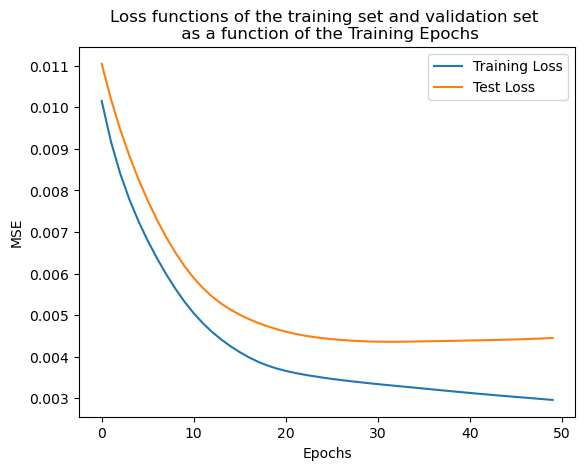

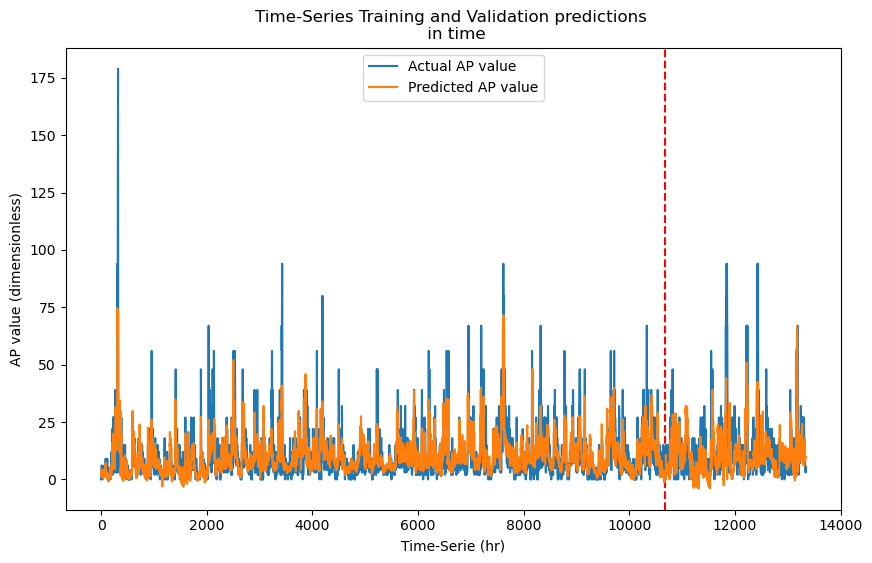

In [13]:
df_X_ss = ss.transform(df.drop(columns=['AP'])) # old transformers
df_y_mm = mm.transform(df["AP"].values.reshape(-1, 1)) # old transformers
# split the sequence


df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 50)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.plot(range(0,n_epochs),Train_loss_array)
plt.plot(range(0,n_epochs), Test_loss_array)
plt.legend(["Training Loss","Test Loss"])
plt.title("Loss functions of the training set and validation set \n as a function of the Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.savefig("Training_plot.png", dpi=300)
plt.show()

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=0.8*len(true), c='r', linestyle='--') # size of the training set
plt.plot(true, label='Actual AP value') # actual plot
plt.plot(preds, label='Predicted AP value') # predicted plot
plt.title('Time-Series Training and Validation predictions \n in time')
plt.xlabel("Time-Serie (hr)")
plt.ylabel("AP value (dimensionless)")
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

Test pour faire la prédiction d'un ensemble de 100 données situées dans le dataset

Testing Shape: (19852, 100, 58) (19852, 50)


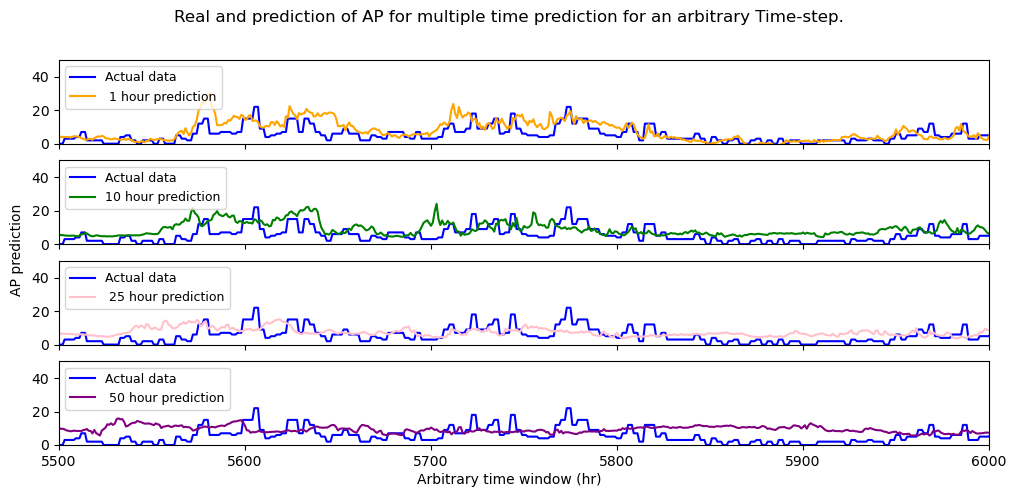

In [14]:
#test autre temps
df = df1[20000:40000]
X, y = df.drop(columns=["AP"]), df.AP.values
X.shape,y.shape


mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)

X_test = X_ss
y_test = y_mm 

X_test_tensors = Variable(torch.Tensor(X_test))
y_test_tensors = Variable(torch.Tensor(y_test))

X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Testing Shape:", X_test.shape, y_test.shape) 

test_predict = lstm.forward(X_test_tensors_final) # get the specified

test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict) # reverse transformation

nb_of_hours = [0,9,24,49]

prediction_array = []
for j in nb_of_hours:
    prediction= []
    for i in range(0,len(test_predict)):
        prediction.append((test_predict[i][j]))
    prediction_array.append(prediction)

mylegends = [" 1 hour prediction", "10 hour prediction", " 25 hour prediction", " 50 hour prediction"]
colors = ['Orange','green', 'pink', 'purple']

fig, axs = plt.subplots(4, sharex=True)
fig.set_figheight(5)
fig.set_figwidth(12)
a = [x for x in range(0, len(y))]
for i in range(len(nb_of_hours)):
    axs[i].plot(a, y, label='Actual data', color="blue")
    c = [x+(100-nb_of_hours[i]) for x in range(0, len(test_predict))] 
    axs[i].plot(c, prediction_array[i], color=colors[i], label = mylegends[i])
    axs[i].legend(loc='upper left', fontsize="9")
    axs[i].set_xlim(5500,6000)
    axs[i].set_ylim(0,50)
fig.suptitle("Real and prediction of AP for multiple time prediction for an arbitrary Time-step.")
fig.text(0.5, 0.04, 'Arbitrary time window (hr)', ha='center', va='center')
fig.text(0.09, 0.5, 'AP prediction', ha='center', va='center', rotation='vertical')
plt.savefig("AI_YOUHOU.png", dpi=300)
plt.show()

